In [1]:
import tensorflow as tf
import numpy as np

In [2]:
vgg = tf.keras.applications.VGG19()
vgg.summary()

W1127 20:49:59.574048 25348 deprecation.py:506] From C:\Users\Gencho\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
#input_tensor = tf.keras.Input(shape = (224, 224, 3))
vgg = tf.keras.applications.VGG19(weights ='imagenet')

vgg.trainable = False
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
labels = 20
grid_size = 7
boxes_per_grid_cell = 2

In [5]:
layers = vgg.layers[:-1]
object_detection_predictions_layer = tf.keras.layers.Dense(units = grid_size * grid_size * (5 * boxes_per_grid_cell + labels))

layers.append(object_detection_predictions_layer)
#layers.append(tf.keras.layers.Reshape(target_shape=(grid_size, grid_size, (5 * boxes_per_grid_cell + labels))))

model = tf.keras.Sequential(layers, "object detector")
model.summary()

Model: "object detector"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)   

In [6]:
Lcoord = 5
Lnoobj = 0.5

In [7]:
def custom_loss(y_true, y_pred):
    '''
    output tensor:
    
    for each cell:
        for each bounding box:
            x, y, w, h, C(any)
        for each class:
            C(class)
    
    flattened
    '''

    
    #TODO: translate every operation to tensorflow?
    
    loss = tf.constant(0.0)
    
    step_size = 5 * boxes_per_grid_cell + labels
    
    def get_true_pred(index):
        return y_true[:, index], y_pred[:, index]
    
    for cell in range(grid_size ** 2):
        index = cell * step_size # 0
        
        '''
        TODO:
        At training time we only want one bounding box predictor to be responsible for each object. 
        We assign one predictor to be “responsible” for predicting an object based on which 
        prediction has the highest current IOU with the ground truth.
        We optimise the x,y,w,h,c of that box with Lcoord factor and just c of the others with Lnoobj factor        
        For ci we optimise for every box
        
        TODO:
        Rearrange tensor shapes (first w, y, w, h, c for each box, then ci for each box)?
        Reshape to 3d tensor instead of linear per prediction?
        '''        
    
        for box in range(boxes_per_grid_cell):
            inner_step_size = box * 5
            
            
            xtrue, xpred = get_true_pred(inner_step_size + index)
            ytrue, ypred = get_true_pred(inner_step_size + index + 1)
            wtrue, wpred = get_true_pred(inner_step_size + index + 2)
            htrue, hpred = get_true_pred(inner_step_size + index + 3)
            Canytrue, Canypred = get_true_pred(inner_step_size + index + 4)
                                  
            
            loss = tf.add(loss, (Lnoobj if Canytrue == 0 else 1) * ((Canytrue - Canypred) ** 2)) 
            
            loss = tf.cond(tf.less(tf.reduce_mean(tf.subtract(1.0, Canytrue)), 0), lambda: tf.add(tf.add(loss, Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)), Lcoord * ((tf.sqrt(wtrue) - tf.sqrt(wpred)) ** 2 + (tf.sqrt(htrue) - tf.sqrt(hpred)) ** 2)), lambda: loss)       
            #if Canytrue:
            #    loss += Lcoord * ((xtrue - xpred) ** 2 + (ytrue - ypred) ** 2)
            #    loss += Lcoord * ((sqrt(wtrue) - sqrt(wpred)) ** 2 + (sqrt(htrue) - sqrt(hpred)) ** 2)
        
        for label in range(labels):
            Clabeltrue, Clabelpred = get_true_pred(index + boxes_per_grid_cell * 5 + label)
            
            loss = tf.add(loss, (Lnoobj if Clabeltrue == 0 else 1) * ((Clabeltrue - Clabelpred) ** 2)) 
                
    return loss
    
    

In [8]:
model.compile(optimizer = "adam", loss = custom_loss)

In [9]:
import xml.etree.ElementTree as ET
import os

path = '.\VOCdevkit\VOC2007\Annotations'

files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xml' in file:
            files.append(os.path.join(r, file))

parsed = [ET.parse(file) for file in files]

allnames = []
uniques = set()

for names in [names for names in [xml.findall('object/name') for xml in parsed]]:
    for name in names:
            allnames.append(name)
            uniques.add(name.text)

print(len(files))
print(len(allnames))

print(uniques)
print(len(uniques))

5011
15662
{'horse', 'diningtable', 'sofa', 'train', 'bird', 'aeroplane', 'person', 'boat', 'bottle', 'motorbike', 'bus', 'cat', 'pottedplant', 'car', 'dog', 'bicycle', 'sheep', 'cow', 'tvmonitor', 'chair'}
20


In [10]:
class Hack(object):
    def __str__(self):
        return f'{self.name} ({self.xmin}, {self.ymin}) ({self.xmax}, {self.ymax})'

def parse_annotation(filepath):
    print(filepath)
    
    objects = []
    
    et = ET.parse(filepath)
    for obj in et.findall('object'):
        curr = Hack()
        for child in obj.iter():
            if child.tag != 'bndbox':
                if(child.text.isdigit()):
                    setattr(curr, child.tag, int(child.text))
                else:
                    setattr(curr, child.tag, child.text)
        objects.append(curr)
        
    
    filename = et.find('filename').text
    width = et.find('size/width').text
    height = et.find('size/height').text
    
    result = Hack()
    setattr(result, 'objects', objects)
    setattr(result, 'imagewidth', int(width))
    setattr(result, 'imageheight', int(height))
    setattr(result, 'filename', filename)
    
    return result

testannotation = r'.\\VOCdevkit\\VOC2007\\Annotations\\000005.xml'

parsedannotation = parse_annotation(testannotation)

print(parsedannotation.filename)
print(parsedannotation.imagewidth)
print(parsedannotation.imageheight)
for obj in parsedannotation.objects:
    print(obj)

.\\VOCdevkit\\VOC2007\\Annotations\\000005.xml
000005.jpg
500
375
chair (263, 211) (324, 339)
chair (165, 264) (253, 372)
chair (5, 244) (67, 374)
chair (241, 194) (295, 299)
chair (277, 186) (312, 220)


In [11]:
'''
notes:
    normalize bounding box width and height according to image width and height so that they fall between 0 and 1
    normalize x, y according to the box
'''

def decode_predictions(output):
    #TODO: Implement
    
    pass

def get_expected_output_from_annotations(annotation_path):
    parsed = parse_annotation(annotation_path)
    
    expected = np.zeros(grid_size * grid_size * (5 * boxes_per_grid_cell + labels))
    
    rowstep = parsed.imageheight / grid_size
    colstep = parsed.imagewidth / grid_size
    
    grid = [[[] for i in range(grid_size)] for i in range(grid_size)]
    
    for obj in parsed.objects:
        obj.xmid = (obj.xmax + obj.xmin) / 2
        obj.ymid = (obj.ymax + obj.ymin) / 2
        obj.width = obj.xmax - obj.xmin
        obj.height = obj.ymax - obj.ymin
                
        row = int(obj.ymid / rowstep)
        col = int(obj.xmid / colstep)
        
        grid[row][col].append(obj)
    
    tensorindex = 0
    for row in range(grid_size):
        for col in range(grid_size):
            objects = grid[row][col]                     
            
            # calculate bounding boxes
            boxleftstart = col * colstep
            boxbottomstart = row * rowstep
            
            for box in range(boxes_per_grid_cell):
                if len(objects) > box:
                    obj = objects[box]              
                                        
                    expected[tensorindex] = (obj.xmid - boxleftstart) / colstep #x regarding box left border scaled to box width
                    expected[tensorindex + 1] = (obj.ymid - boxbottomstart) / rowstep #y regarding box bottom border scaled to box height              
                    expected[tensorindex + 2] = obj.width / parsed.imagewidth
                    expected[tensorindex + 3] = obj.height / parsed.imageheight
                    expected[tensorindex + 4] = 1 #confidence
                    
                tensorindex += 5
                
            #TODO: implement             
            # encode and mark classes present in celll
            tensorindex += labels               
    
    
    return expected

#with np.printoptions(threshold=np.inf):
#    print(get_expected_output_from_annotations(testannotation))
get_expected_output_from_annotations(testannotation)

.\\VOCdevkit\\VOC2007\\Annotations\\000005.xml


array([0., 0., 0., ..., 0., 0., 0.])

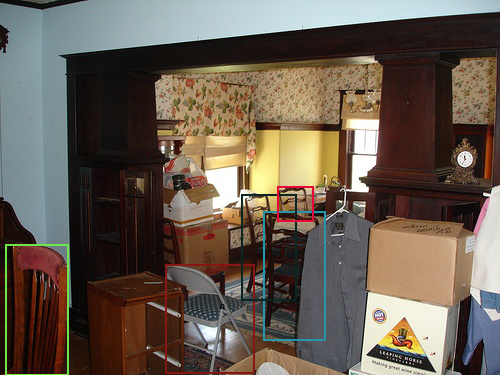

In [12]:
from IPython.core.display import Image, display
from PIL import Image as Img
from PIL import ImageDraw as ImgDraw
from random import uniform

image = r'.\\VOCdevkit\\VOC2007\\JPEGImages\\000005.jpg'

def get_color():
    return (int(uniform(0, 255)), int(uniform(0, 255)), int(uniform(0, 255)))

def draw_image(imagepath, objects = []):
    im = Img.open(imagepath)
    
    draw = ImgDraw.Draw(im)
    
    for obj in objects:
        color = get_color()
        
        draw.line((obj.xmin, obj.ymin) + (obj.xmax, obj.ymin), fill = color, width = 2)
        draw.line((obj.xmin, obj.ymax) + (obj.xmax, obj.ymax), fill = color, width = 2)
        draw.line((obj.xmin, obj.ymin) + (obj.xmin, obj.ymax), fill = color, width = 2)
        draw.line((obj.xmax, obj.ymin) + (obj.xmax, obj.ymax), fill = color, width = 2)
    
    display(im)


draw_image(image, parsedannotation.objects)